In [23]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import seaborn
import pandas as pd

In [24]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.Grayscale(num_output_channels=1)
])

In [25]:
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.Grayscale(num_output_channels=1) 
])

In [26]:
train_dataset = datasets.ImageFolder(root='train', transform=train_transforms)
test_dataset = datasets.ImageFolder(root='validation', transform=test_transforms)

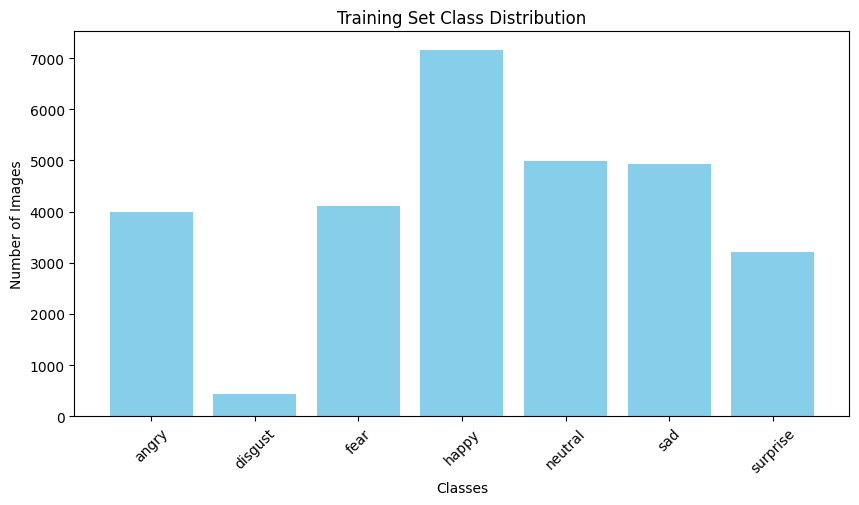

Class counts: {'angry': 3993, 'disgust': 436, 'fear': 4103, 'happy': 7164, 'neutral': 4982, 'sad': 4938, 'surprise': 3205}


In [27]:
import os 

def count_images_per_class(dataset_path):
    class_counts = {}
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

train_class_counts = count_images_per_class('train')

def plot_class_distribution(class_counts, title):
    classes = list(class_counts.keys())
    counts = list(class_counts.values())
    
    plt.figure(figsize=(10, 5))
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(train_class_counts, 'Training Set Class Distribution')
print("Class counts:", train_class_counts)


In [28]:
class_names = train_dataset.classes
class_names

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [29]:
img,labels = train_dataset[5]
input_shape = img.shape[-1]
num_classes = len(train_dataset.classes)
(input_shape,num_classes)


(48, 7)

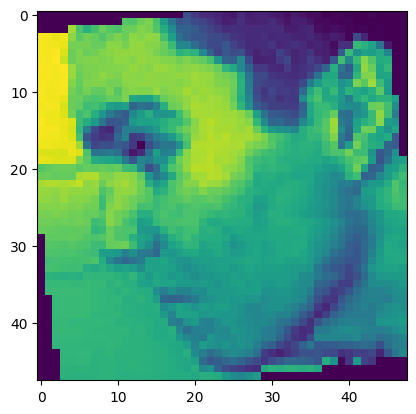

In [30]:
plt.imshow(np.transpose(img, (1, 2, 0)))
plt.show()

In [31]:
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0337124..2.3987303].


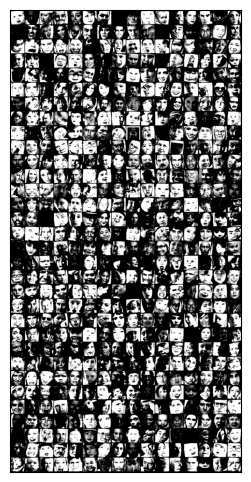

In [32]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break
show_batch(train_loader)

In [33]:
num_epochs = 40
lr = 0.0001

In [34]:
def conv_block(in_channels,out_channels,stride=1,pool=False):
    layers = [
        nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1,stride=stride,bias=False),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(negative_slope=0.01, inplace=True),
    ]
    if pool:
        layers.append (nn.AvgPool2d(2))
    return nn.Sequential(*layers)

In [35]:
class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes,res_weights):
        super().__init__()
        
        # Initial convolution
        self.conv1 = conv_block(in_channels, 64, stride=2)  # 64 x 24 x 24
        
        # First stack
        self.conv2 = conv_block(64, 64)  # 64 x 24 x 24
        self.res1 = nn.Sequential(
            conv_block(64, 64),
            conv_block(64, 64)
        )
        
        # Second stack
        self.conv3 = conv_block(64, 128, stride=2)  # 128 x 12 x 12
        self.res2 = nn.Sequential(
            conv_block(128, 128),
            conv_block(128, 128)
        )
        
        # Third stack
        self.conv4 = conv_block(128, 256, stride=2)  # 256 x 6 x 6
        self.res3 = nn.Sequential(
            conv_block(256, 256),
            conv_block(256, 256)
        )
        
        # Fourth stack
        self.conv5 = conv_block(256, 512, stride=2)  # 512 x 3 x 3
        self.res4 = nn.Sequential(
            conv_block(512, 512),
            conv_block(512, 512)
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # 512 x 1 x 1
            nn.Flatten(),  # 512
            nn.Dropout(0.5),
            nn.Linear(512, 256),  # 256
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)  # num_classes
        )
        
    def forward(self, x):
        x = self.conv1(x)
        
        x = self.conv2(x)
        x = self.res1(x) + res_weights*x
        
        x = self.conv3(x)
        x = self.res2(x) + res_weights*x
        
        x = self.conv4(x)
        x = self.res3(x) + res_weights*x
        
        x = self.conv5(x)
        x = self.res4(x) + res_weights*x
        
        x = self.classifier(x)
        
        return x

In [38]:
device = torch.device('cuda')

In [39]:
model = ResNet(1,7,res_weights=0.5).to(device)
model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [40]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=lr)


In [41]:
import matplotlib.pyplot as plt

def train(train_loader, model, criterion, optimizer, num_epochs):
    train_losses = []
    train_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        total_correct = 0
        total_samples = 0
        total_loss = 0.0
        train_loader = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False)

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            total_loss += loss.item()
        
        epoch_loss = total_loss / len(train_loader)
        epoch_acc = total_correct / total_samples * 100
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        
        
        
        if ((epoch+1)%5==0):
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.2f}%')

    epochs = range(1, num_epochs + 1)
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.title('Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'r', label='Training accuracy')
    plt.title('Training accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.show()



    
    
    
    
    

In [42]:
def train(train_loader, test_loader, model, criterion, optimizer, num_epochs):
    train_losses = []
    train_accuracies = []
    test_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        total_correct = 0
        total_samples = 0
        total_loss = 0.0
        train_loader = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False)

        # Training phase
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            total_loss += loss.item()
        
        epoch_loss = total_loss / len(train_loader)
        epoch_acc = total_correct / total_samples * 100
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        # Evaluation phase on test set
        model.eval()
        with torch.no_grad():
            total_correct_test = 0
            total_samples_test = 0
            
            for images_test, labels_test in test_loader:
                images_test = images_test.to(device)
                labels_test = labels_test.to(device)
                
                outputs_test = model(images_test)
                _, predicted_test = torch.max(outputs_test, 1)
                total_correct_test += (predicted_test == labels_test).sum().item()
                total_samples_test += labels_test.size(0)
            
            epoch_acc_test = total_correct_test / total_samples_test * 100
            test_accuracies.append(epoch_acc_test)
        
        # Print training and test results
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.2f}%, '
              f'Test Accuracy: {epoch_acc_test:.2f}%')

    epochs = range(1, num_epochs + 1)
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.title('Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'r', label='Training accuracy')
    plt.title('Training accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.show()


        
        
    

Epoch [1/40], Train Loss: 1.8163, Train Accuracy: 24.84%, Test Accuracy: 31.19%


Epoch [2/40], Train Loss: 1.5988, Train Accuracy: 37.57%, Test Accuracy: 42.33%


Epoch [3/40], Train Loss: 1.4792, Train Accuracy: 42.78%, Test Accuracy: 43.69%


Epoch [4/40], Train Loss: 1.4007, Train Accuracy: 46.43%, Test Accuracy: 47.91%


Epoch [5/40], Train Loss: 1.3312, Train Accuracy: 49.42%, Test Accuracy: 47.35%


Epoch [6/40], Train Loss: 1.2727, Train Accuracy: 52.11%, Test Accuracy: 48.64%


Epoch [7/40], Train Loss: 1.2187, Train Accuracy: 54.14%, Test Accuracy: 52.17%


Epoch [8/40], Train Loss: 1.1618, Train Accuracy: 56.74%, Test Accuracy: 51.84%


Epoch [9/40], Train Loss: 1.1308, Train Accuracy: 57.81%, Test Accuracy: 53.17%


Epoch [10/40], Train Loss: 1.0855, Train Accuracy: 59.68%, Test Accuracy: 54.85%


Epoch [11/40], Train Loss: 1.0432, Train Accuracy: 61.44%, Test Accuracy: 53.16%


Epoch [12/40], Train Loss: 1.0033, Train Accuracy: 62.82%, Test Accuracy: 55.55%


Epoch [13/40], Train Loss: 0.9670, Train Accuracy: 64.69%, Test Accuracy: 54.56%


Epoch [14/40], Train Loss: 0.9281, Train Accuracy: 66.18%, Test Accuracy: 53.96%


Epoch [15/40], Train Loss: 0.8909, Train Accuracy: 67.75%, Test Accuracy: 54.50%


Epoch [16/40], Train Loss: 0.8436, Train Accuracy: 69.60%, Test Accuracy: 55.73%


Epoch [17/40], Train Loss: 0.8194, Train Accuracy: 70.42%, Test Accuracy: 54.15%


Epoch [18/40], Train Loss: 0.7675, Train Accuracy: 72.30%, Test Accuracy: 54.76%


Epoch [19/40], Train Loss: 0.7495, Train Accuracy: 73.28%, Test Accuracy: 56.10%


Epoch [20/40], Train Loss: 0.7047, Train Accuracy: 74.92%, Test Accuracy: 56.85%


Epoch [21/40], Train Loss: 0.6732, Train Accuracy: 76.05%, Test Accuracy: 58.17%


Epoch [22/40], Train Loss: 0.6363, Train Accuracy: 77.87%, Test Accuracy: 54.02%


Epoch [23/40], Train Loss: 0.6111, Train Accuracy: 78.79%, Test Accuracy: 55.68%


Epoch [24/40], Train Loss: 0.5755, Train Accuracy: 80.02%, Test Accuracy: 56.21%


Epoch [25/40], Train Loss: 0.5352, Train Accuracy: 81.16%, Test Accuracy: 57.20%


Epoch [26/40], Train Loss: 0.5185, Train Accuracy: 82.16%, Test Accuracy: 57.03%


Epoch [27/40], Train Loss: 0.4829, Train Accuracy: 83.49%, Test Accuracy: 55.86%


Epoch [28/40], Train Loss: 0.4700, Train Accuracy: 83.61%, Test Accuracy: 57.13%


Epoch [29/40], Train Loss: 0.4448, Train Accuracy: 84.85%, Test Accuracy: 53.99%


Epoch [30/40], Train Loss: 0.4001, Train Accuracy: 86.38%, Test Accuracy: 56.17%


Epoch [31/40], Train Loss: 0.3981, Train Accuracy: 86.31%, Test Accuracy: 55.29%


Epoch [32/40], Train Loss: 0.3790, Train Accuracy: 87.21%, Test Accuracy: 57.40%


Epoch [33/40], Train Loss: 0.3601, Train Accuracy: 87.69%, Test Accuracy: 57.57%


Epoch [34/40], Train Loss: 0.3324, Train Accuracy: 88.67%, Test Accuracy: 58.76%


Epoch [35/40], Train Loss: 0.3149, Train Accuracy: 89.29%, Test Accuracy: 58.55%


Epoch [36/40], Train Loss: 0.3133, Train Accuracy: 89.45%, Test Accuracy: 58.66%


Epoch [37/40], Train Loss: 0.2967, Train Accuracy: 89.81%, Test Accuracy: 56.26%


Epoch [38/40], Train Loss: 0.2732, Train Accuracy: 90.86%, Test Accuracy: 57.05%


Epoch [39/40], Train Loss: 0.2706, Train Accuracy: 90.98%, Test Accuracy: 57.76%


Epoch [40/40], Train Loss: 0.2550, Train Accuracy: 91.46%, Test Accuracy: 58.90%


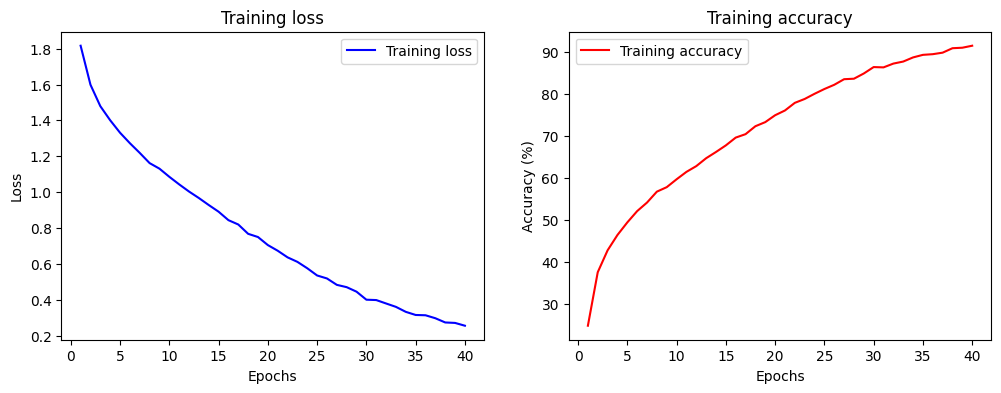

In [44]:
train(train_loader, test_loader, model, criterion, optimizer, num_epochs)


In [45]:
torch.save(model.state_dict(), 'expression_classifer.pth')


Accuracy: 0.92


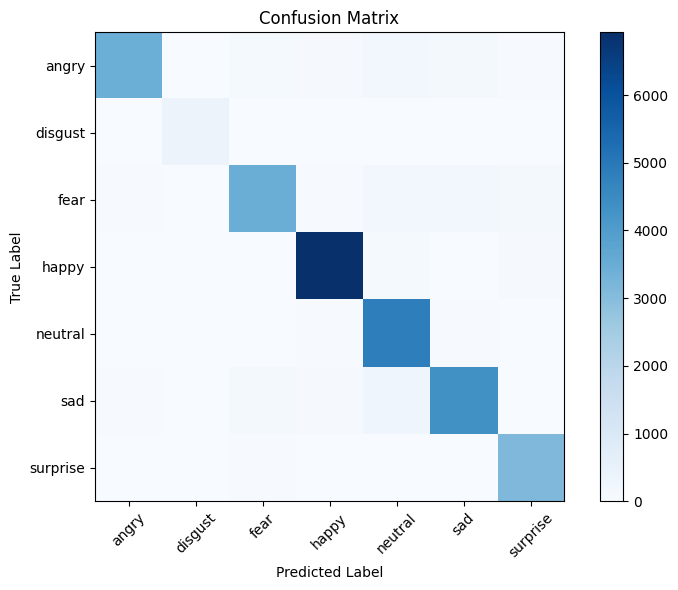

              precision    recall  f1-score   support

       angry       0.96      0.86      0.91      3993
     disgust       0.91      0.93      0.92       436
        fear       0.92      0.85      0.88      4103
       happy       0.97      0.97      0.97      7164
     neutral       0.85      0.97      0.91      4982
         sad       0.91      0.88      0.90      4938
    surprise       0.91      0.97      0.94      3205

    accuracy                           0.92     28821
   macro avg       0.92      0.92      0.92     28821
weighted avg       0.92      0.92      0.92     28821



In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

predictions = np.array(predictions)
true_labels = np.array(true_labels)
accuracy = np.mean(predictions == true_labels)
print(f'Accuracy: {accuracy:.2f}')

class_names = train_dataset.classes
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

print(classification_report(true_labels, predictions, target_names=class_names))

Testing Accuracy: 0.59


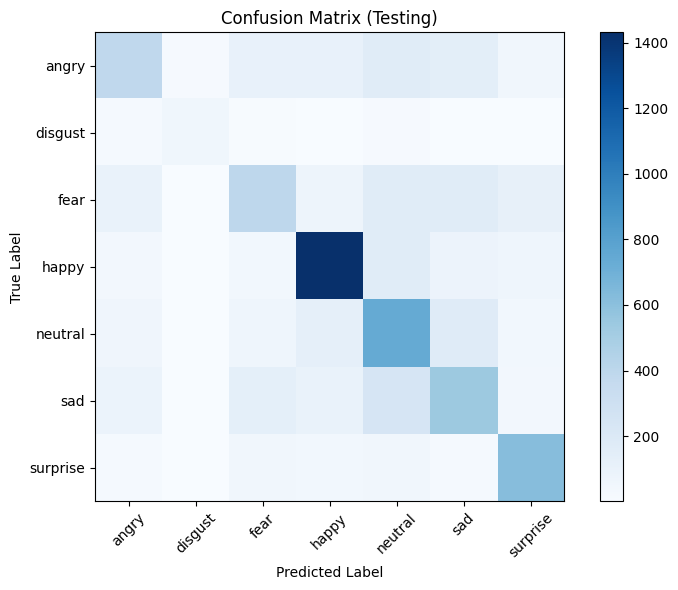

              precision    recall  f1-score   support

       angry       0.54      0.40      0.46       960
     disgust       0.63      0.50      0.56       111
        fear       0.49      0.39      0.43      1018
       happy       0.76      0.78      0.77      1825
     neutral       0.48      0.61      0.54      1216
         sad       0.48      0.47      0.48      1139
    surprise       0.67      0.78      0.72       797

    accuracy                           0.59      7066
   macro avg       0.58      0.56      0.56      7066
weighted avg       0.59      0.59      0.58      7066



In [47]:

model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

predictions = np.array(predictions)
true_labels = np.array(true_labels)
accuracy = np.mean(predictions == true_labels)
print(f'Testing Accuracy: {accuracy:.2f}')

conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Testing)')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

print(classification_report(true_labels, predictions, target_names=class_names))

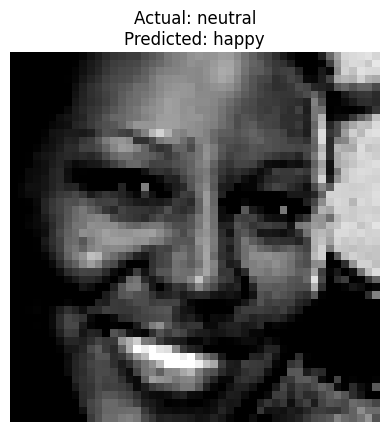

Image 4260:
Actual class: neutral
Predicted class: happy
------------------------


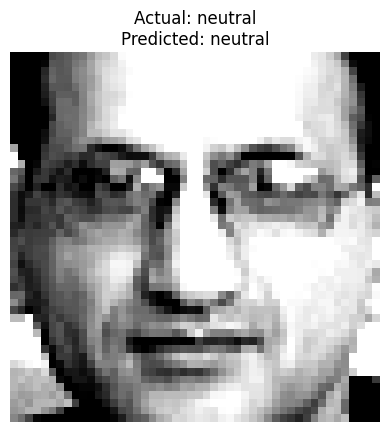

Image 3997:
Actual class: neutral
Predicted class: neutral
------------------------


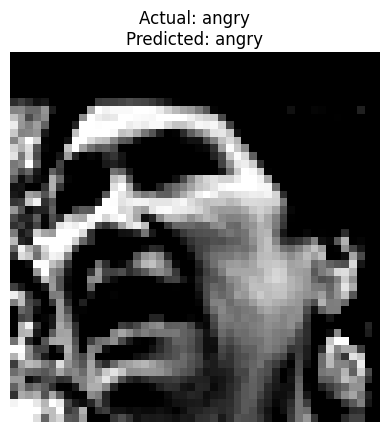

Image 424:
Actual class: angry
Predicted class: angry
------------------------


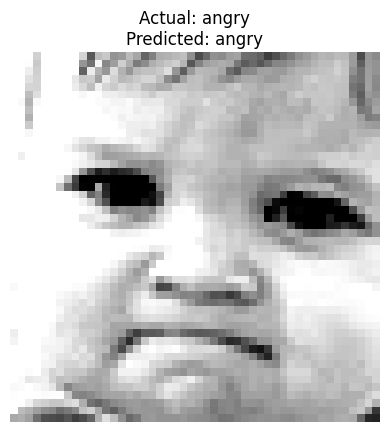

Image 598:
Actual class: angry
Predicted class: angry
------------------------


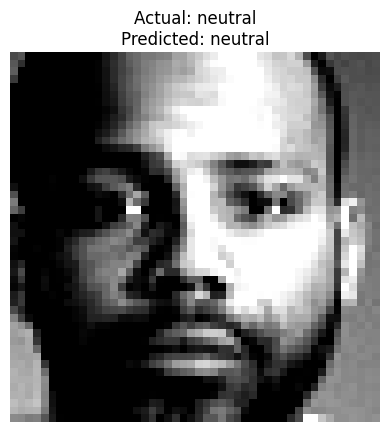

Image 4224:
Actual class: neutral
Predicted class: neutral
------------------------


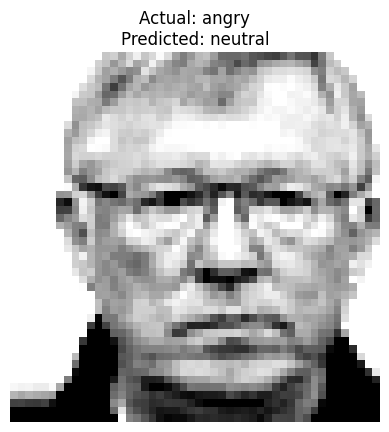

Image 67:
Actual class: angry
Predicted class: neutral
------------------------


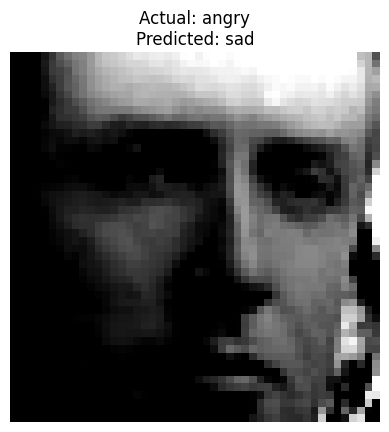

Image 100:
Actual class: angry
Predicted class: sad
------------------------


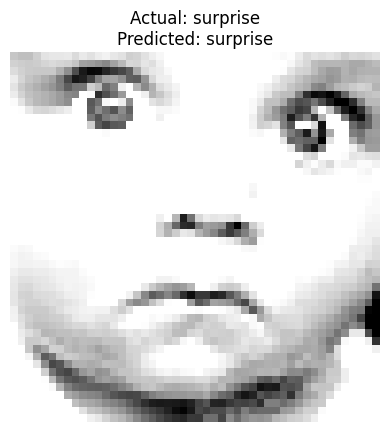

Image 6851:
Actual class: surprise
Predicted class: surprise
------------------------


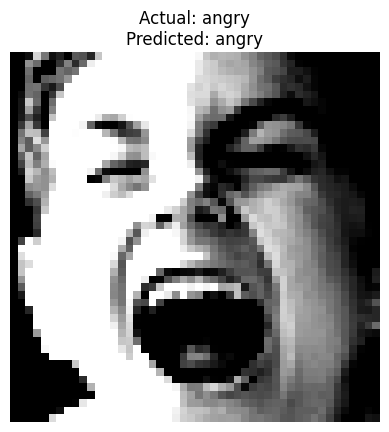

Image 60:
Actual class: angry
Predicted class: angry
------------------------


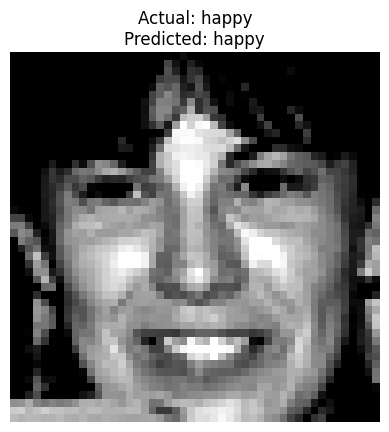

Image 2566:
Actual class: happy
Predicted class: happy
------------------------


In [48]:
import torch
import matplotlib.pyplot as plt
import random
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.eval()



def imshow(img):
    img = img.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')

total_images = len(test_loader.dataset)

random_indices = random.sample(range(total_images), 10)

for idx in random_indices:
    image, label = test_loader.dataset[idx]
    
    image = image.unsqueeze(0).to(device)
    label = torch.tensor(label).to(device)

    with torch.no_grad():
        output = model(image)
    
    _, predicted = torch.max(output, 1)

    plt.figure()
    imshow(image.squeeze(0).cpu())
    plt.title(f"Actual: {class_names[label.item()]}\nPredicted: {class_names[predicted.item()]}")
    plt.show()

    print(f"Image {idx}:")
    print(f"Actual class: {class_names[label.item()]}")
    print(f"Predicted class: {class_names[predicted.item()]}")
    print("------------------------")